In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 10.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=c466f310ef945ad2eec5ba1d541d3f1252004994ced33b044b4afad86a1ca1a8
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import japanize_matplotlib

In [5]:
current_dir=os.getcwd()
current_dir

'/content'

In [6]:
cd /content/drive/MyDrive/input/

/content/drive/MyDrive/input


In [7]:
os.listdir(current_dir)

['.config', 'drive', 'sample_data']

In [8]:
ls

holidays_events.csv  sample_submission.csv  stores.csv  train_df1.csv
oil.csv              store_sales.csv        train.csv   transactions.csv


In [52]:
#読み込み
train = pd.read_csv("store_sales.csv")

In [53]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale,locale_name,description,transferred,transactions,Day,Week,Month,Year,Weekday
0,0,2013-01-01,1,0,0.0,0,0.0,4,2,5,51,0,0.0,1,1,1,2013,1
1,1194,2013-01-01,42,6,0.0,0,0.0,4,2,5,51,0,0.0,1,1,1,2013,1
2,1193,2013-01-01,42,5,0.0,0,0.0,4,2,5,51,0,0.0,1,1,1,2013,1
3,1192,2013-01-01,42,4,0.0,0,0.0,4,2,5,51,0,0.0,1,1,1,2013,1
4,1191,2013-01-01,42,3,0.0,0,0.0,4,2,5,51,0,0.0,1,1,1,2013,1


In [54]:
train=train.drop('date', axis=1)

In [55]:
pd.DataFrame(train.dtypes, columns=['Type']).T

,id,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale,locale_name,description,transferred,transactions,Day,Week,Month,Year,Weekday
Type,int64,int64,int64,float64,int64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64


In [56]:
X=train.drop('sales',axis=1)
Y=train['sales']
# Y=np.expand_dims(Y,1)

In [57]:

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
# 評価指標
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE


In [58]:
params ={
    'objective':'regression',
    'metric':'neg_mean_squared_log_error'
}

In [59]:
from sklearn.model_selection import TimeSeriesSplit

In [60]:
folds = TimeSeriesSplit(n_splits=5)

In [61]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame({'R2': R2(true, pred),
                          'MAE': MAE(true, pred),
                          'MSE': MSE(true, pred),
                          'RMSE': np.sqrt(MSE(true, pred))},
                           index = ['scores'])
    return scores



for i,(train_index,test_index) in enumerate(folds.split(X)):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    Y_train,Y_test = Y.iloc[train_index],Y.iloc[test_index]
    # Y_train = np.log1p(Y_train)
    scaler = StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)

    train_data=lgb.Dataset(X_train,Y_train)
    eval_data=lgb.Dataset(X_test,Y_test,reference=train_data)
    gbm = lgb.train(
        params,
        train_data,
        valid_sets=[train_data,eval_data])
    pred = gbm.predict(X_test)
    # pred=np.expm1(pred)
    pred=np.expand_dims(pred,1)
    scores = calculate_scores(Y_test, pred)
    print(scores)

             R2        MAE            MSE        RMSE
scores  0.80585  92.451885  154029.421576  392.465822
              R2         MAE            MSE        RMSE
scores  0.787147  140.218719  219899.836001  468.934789
              R2         MAE            MSE        RMSE
scores  0.825237  149.697759  252409.456115  502.403678
              R2         MAE            MSE        RMSE
scores  0.852323  153.850992  241354.019888  491.277946
              R2         MAE            MSE        RMSE
scores  0.924521  145.960535  144007.825906  379.483631


In [32]:
np.expm1(pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in expm1
  """Entry point for launching an IPython kernel.


array([1.35591719e+34,            inf, 5.93843617e+02, ...,
       1.32488954e+46, 1.44331907e+00, 5.32962937e+06])

In [39]:
np.expand_dims(pred)

TypeError: ignored

In [33]:
pred

array([7.85923713e+01, 1.28620318e+03, 6.38829854e+00, ...,
       1.06200243e+02, 8.93357390e-01, 1.54887924e+01])

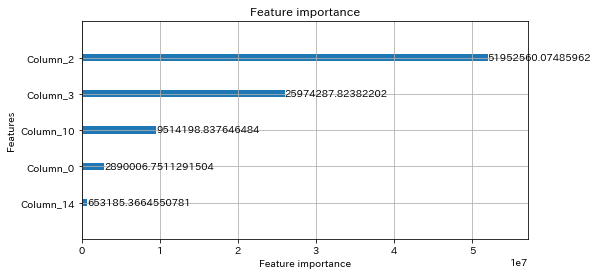

In [18]:
lgb.plot_importance(gbm, figsize=(8,4), max_num_features=5, importance_type='gain')

In [19]:
!pip install shap

import shap

#notebook内でJavascriptを動かすためのおまじない
shap.initjs()

"""
shap.TreeExplainer:決定木用(XGBoost、lightBGM等含む)
shap.LinearExplainer :線形モデル用
shap.DeepExplainer :Deeplearning用
"""
#TreeExplainerは、決定木系のモデルのSHAP値を取得するもの。
explainer = shap.TreeExplainer(model=gbm)

print(explainer.expected_value)

[2.80200949]


In [20]:
"""
modelと解釈したいデータを渡す　
※なお、indexのresetは別に不要ですがtestデータのindexが何番かをいちいち確認するのが面倒なのでresetしてます。
"""
X_test_shap = X_test.copy()
# X_test_shap = X_test.copy().reset_index(drop=True)
shap_values = explainer.shap_values(X=X_test_shap)

print(X_test_shap.shape)
print(shap_values.shape)
print(shap_values[0])#テストデータの0番目の要素を出力

(509058, 16)
(509058, 16)
[ 1.26541010e-01 -9.21215810e-02 -6.20842767e-02  1.15166681e+00
 -5.99651039e-02  1.89566992e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.07906516e-01 -5.40216541e-03
  1.07744763e-02  2.63450992e-02  1.93352991e-02  5.18937195e-02]


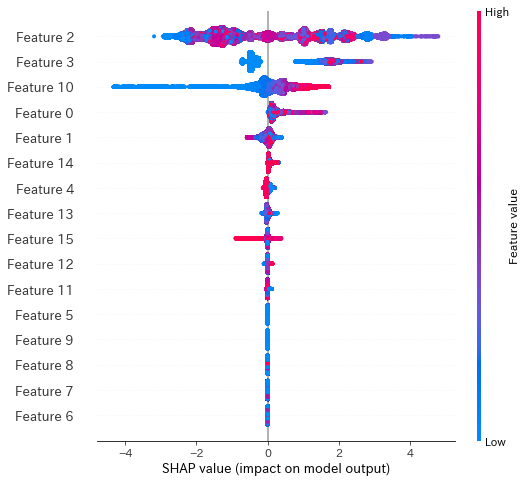

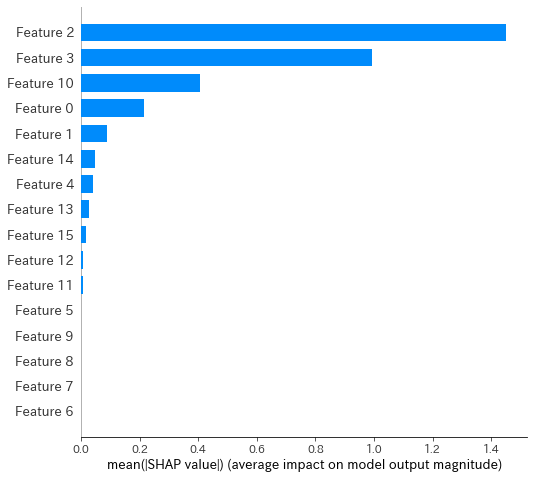

In [21]:
shap.summary_plot(shap_values, X_test_shap) #左側の図
shap.summary_plot(shap_values, X_test_shap, plot_type='bar') #右側の図

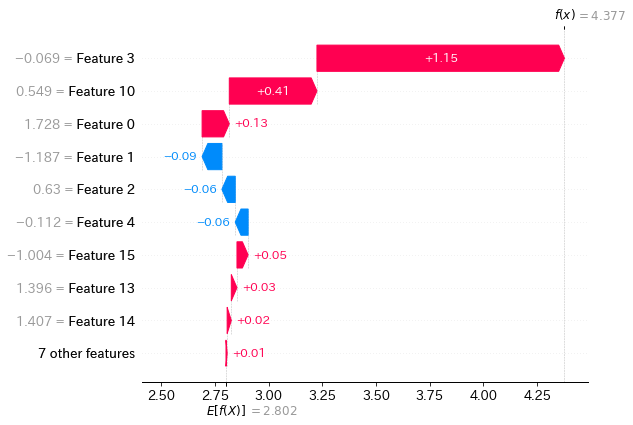

In [25]:
n = 0#テストデータのn番目の要素を指定

shap.force_plot(explainer.expected_value, shap_values[n], X_test_shap[n])#上の図

#waterfall_plotは私の環境ではエラーになるので、代わりにwaterfall_legacyを使用している。
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, 
                                       shap_values[n], X_test_shap[n]) #下の図

In [26]:
n = 0
print(gbm.predict(X_test_shap)[n])

4.3769182500239765


In [30]:
import shap
shap.initjs()

explainer = shap.Explainer(gbm) #TreeExplainerでも多分変わらないが・・
shap_values = explainer(X_test_shap) #これで全確認データの数字を一気に入手
n = 0 #0番目のテストデータのSHAPを確認したい
print('shap値：', shap_values[n].values) #n番目テストデータのSHAP値
print('基礎スコア：', shap_values[n].base_values) #n番目テストデータの基礎スコア
print('説明変数値：', shap_values[n].data) #n番目テストデータの説明変数数値

shap値： [ 1.26541010e-01 -9.21215810e-02 -6.20842767e-02  1.15166681e+00
 -5.99651039e-02  1.89566992e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.07906516e-01 -5.40216541e-03
  1.07744763e-02  2.63450992e-02  1.93352991e-02  5.18937195e-02]
基礎スコア： 2.8020094910627367
説明変数値： [ 1.7276345  -1.18709068  0.63012503 -0.06852384 -0.1123137  -0.42158057
 -0.41425806 -0.3524738  -0.35049612 -0.05926956  0.54874252 -0.86956595
  1.3138684   1.39633032  1.4074262  -1.00371205]


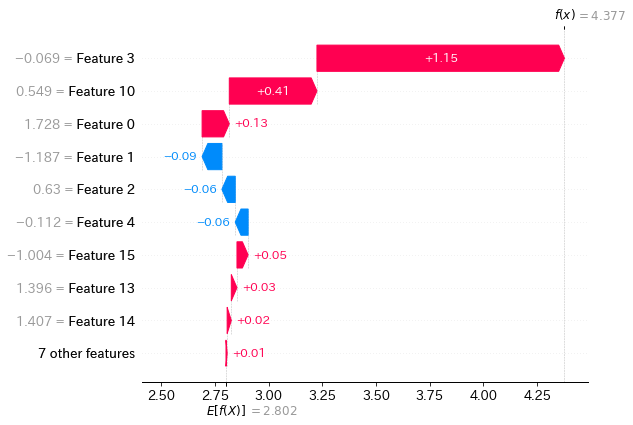

In [31]:
#n番目のテストデータのwaterfall_plot
shap.plots.waterfall(shap_values[n]) #記事では_waterfall.waterfall_legacyだったが・・